### There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating its employees fairly.
### Specifically, she gave you the following tasks:
#### (1) In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
- Individual Contributors (IC): they don't manage anyone 

- Middle Managers (MM): they are the direct bosses of IC 

- Directors (D): they are the direct bosses of MM

- VP: D direct bosses

- Executives (E): VP direct bosses

- CEO: The direct boss of E.

#### (2) How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

#### (3) Build a model to predict the salary of each employee. Describe the main factors impacting employee salaries. 

#### (4) Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

### Load the package would be used

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

### Read in the data set

In [2]:
company = pd.read_csv("../Datasets/HR/company_hierarchy.csv")
employee = pd.read_csv("../Datasets/HR/employee.csv")

### Look into data

In [3]:
print(employee.shape)
print(company.shape)

print(employee.head)
print(company.head)

print(employee.info)
print(company.info)

print(len(employee["employee_id"]) == len(pd.unique(employee["employee_id"])))
print(len(company["employee_id"]) == len(pd.unique(company["employee_id"])))

print(list(employee.columns))
print(list(company.columns))

(10000, 6)
(10000, 3)
<bound method NDFrame.head of       employee_id  signing_bonus    salary degree_level sex  yrs_experience
0          138719              0  273000.0       Master   M               2
1            3192              0  301000.0     Bachelor   F               1
2          114657              0  261000.0       Master   F               2
3           29039              0   86000.0  High_School   F               4
4          118607              0  126000.0     Bachelor   F               3
...           ...            ...       ...          ...  ..             ...
9995        55261              0  307000.0     Bachelor   M               4
9996        84604              0  302000.0          PhD   M               6
9997       193115              1  132000.0     Bachelor   M               4
9998        14249              0   77000.0          PhD   M               4
9999        72227              0  178000.0       Master   M               1

[10000 rows x 6 columns]>
<bound me

### Data processing

In [4]:
dat = employee.merge(company, on = "employee_id", how = "inner")
print(dat.shape)
print(dat.info)
print(list(dat.columns))
print(len(dat["employee_id"]) == len(pd.unique(dat["employee_id"])))
dat.head()

(10000, 8)
<bound method DataFrame.info of       employee_id  signing_bonus    salary degree_level sex  yrs_experience   boss_id         dept
0          138719              0  273000.0       Master   M               2   43602.0  engineering
1            3192              0  301000.0     Bachelor   F               1   87847.0        sales
2          114657              0  261000.0       Master   F               2  180854.0        sales
3           29039              0   86000.0  High_School   F               4   88370.0           HR
4          118607              0  126000.0     Bachelor   F               3   23565.0        sales
...           ...            ...       ...          ...  ..             ...       ...          ...
9995        55261              0  307000.0     Bachelor   M               4   81111.0  engineering
9996        84604              0  302000.0          PhD   M               6   83032.0    marketing
9997       193115              1  132000.0     Bachelor   M       

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


In [5]:
print(dat.groupby(["degree_level"]).size())
print(dat.groupby(["sex"]).size())
print(dat.groupby(["dept"]).size())
print(dat.groupby(["signing_bonus"]).size())
dat.describe()

degree_level
Bachelor       2735
High_School    1657
Master         2786
PhD            2822
dtype: int64
sex
F    3561
M    6439
dtype: int64
dept
CEO               1
HR             1694
engineering    2696
marketing      2010
sales          3599
dtype: int64
signing_bonus
0    6986
1    3014
dtype: int64


,employee_id,signing_bonus,salary,yrs_experience,boss_id
count,10000.000000,10000.000000,10000.000000,10000.000000,9999.000000
mean,100001.855800,0.301400,189111.800000,3.875200,103299.980498
std,57500.488641,0.458889,88973.796898,3.107409,57508.798817
min,40.000000,0.000000,60000.000000,1.000000,79.000000
25%,50574.500000,0.000000,110000.000000,2.000000,55883.000000
50%,99244.500000,0.000000,182000.000000,3.000000,102712.000000
75%,149748.500000,1.000000,255000.000000,5.000000,152288.000000
max,199956.000000,1.000000,700000.000000,34.000000,199950.000000


In [6]:
dat[dat["boss_id"].isnull()]

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
6367,61554,1,700000.0,PhD,M,7,NaN,CEO


#### (1) In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
- Individual Contributors (IC): they don't manage anyone 

- Middle Managers (MM): they are the direct bosses of IC 

- Directors (D): they are the direct bosses of MM

- VP: D direct bosses

- Executives (E): VP direct bosses

- CEO: The direct boss of E.

In [7]:
#### Reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/15.%20Diversity%20in%20the%20Workplace.ipynb
levels = ["CEO", "E", "VP", "D", "MM", "IC"]
dat.loc[dat["dept"] == "CEO", "level"] = "CEO"

for i in range(len(levels) - 1):
    boss_level = levels[i]
    emplpoyee_level = levels[i + 1]
    boss_id = dat[dat["level"] == boss_level]["employee_id"]
    dat.loc[dat["boss_id"].isin(boss_id), "level"] = emplpoyee_level

dat.head()
dat.groupby(["level"]).size()

level
CEO       1
D       160
E         4
IC     9000
MM      800
VP       35
dtype: int64

#### (2) How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [8]:
#### Reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/15.%20Diversity%20in%20the%20Workplace.ipynb
dat["count"] = 0

for i in ["IC", "MM", "D", "VP", "E"]:
    boss_ids = dat[dat["level"] == i]["boss_id"]
    employee_ids = dat[dat["level"] == i]["employee_id"]
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + dat.loc[dat["employee_id"] == e_id, "count"])
        b_counts = int(dat.loc[dat["employee_id"] == b_id, "count"])
        dat.loc[dat["employee_id"] == b_id, "count"] = e_counts + b_counts
dat.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,count
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


#### (3) Build a model to predict the salary of each employee. Describe the main factors impacting employee salaries.

Text(0, 0.5, 'Salary')

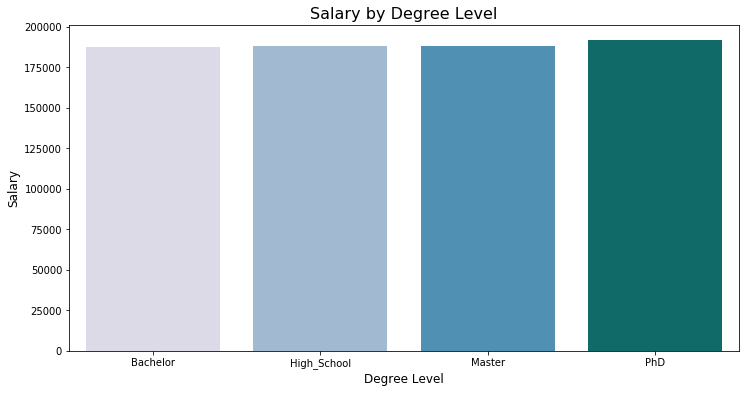

In [9]:
grp_degree = dat[["degree_level", "salary"]].groupby("degree_level").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "degree_level", y = "salary", data = grp_degree, palette = "PuBuGn")
plt.title("Salary by Degree Level", fontsize = 16)
plt.xlabel("Degree Level", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

Text(0, 0.5, 'Salary')

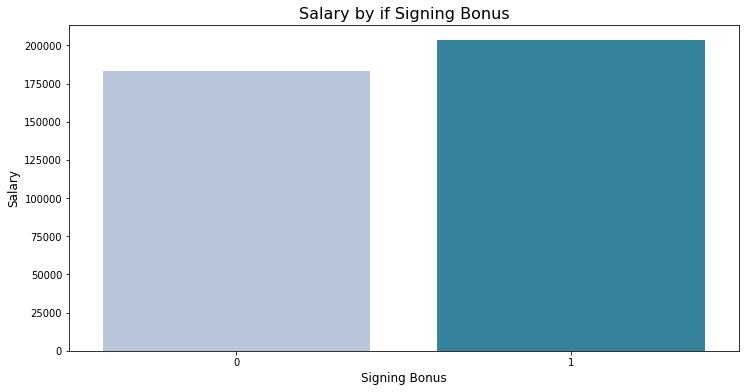

In [10]:
grp_sign_bonus = dat[["signing_bonus", "salary"]].groupby("signing_bonus").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "signing_bonus", y = "salary", data = grp_sign_bonus, palette = "PuBuGn")
plt.title("Salary by if Signing Bonus", fontsize = 16)
plt.xlabel("Signing Bonus", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

Text(0, 0.5, 'Salary')

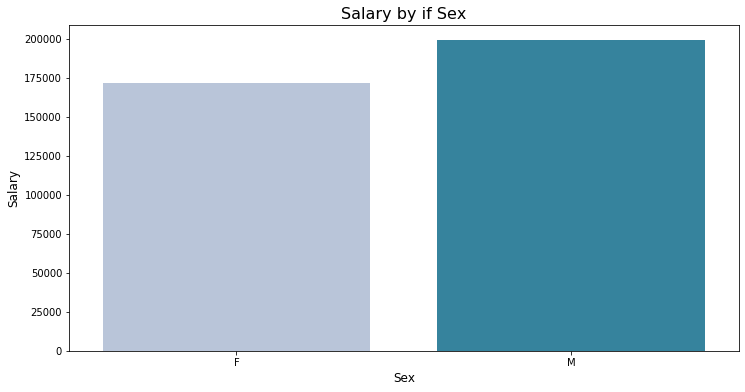

In [11]:
grp_sex = dat[["sex", "salary"]].groupby("sex").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "sex", y = "salary", data = grp_sex, palette = "PuBuGn")
plt.title("Salary by if Sex", fontsize = 16)
plt.xlabel("Sex", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

Text(0, 0.5, 'Salary')

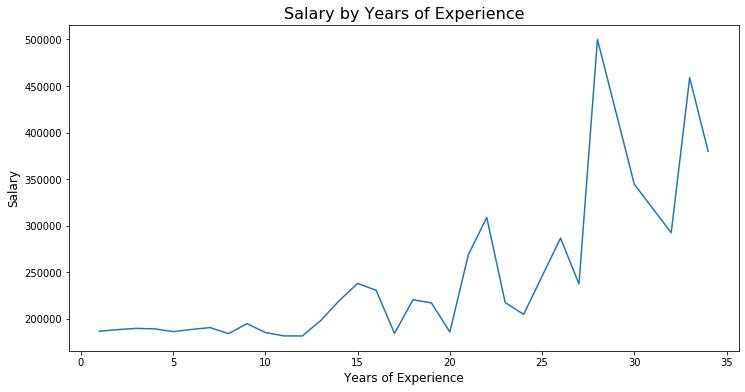

In [12]:
grp_yrs_experience = dat[["yrs_experience", "salary"]].groupby("yrs_experience").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "yrs_experience", y = "salary", data = grp_yrs_experience, palette = "PuBuGn")
plt.title("Salary by Years of Experience", fontsize = 16)
plt.xlabel("Years of Experience", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

Text(0, 0.5, 'Salary')

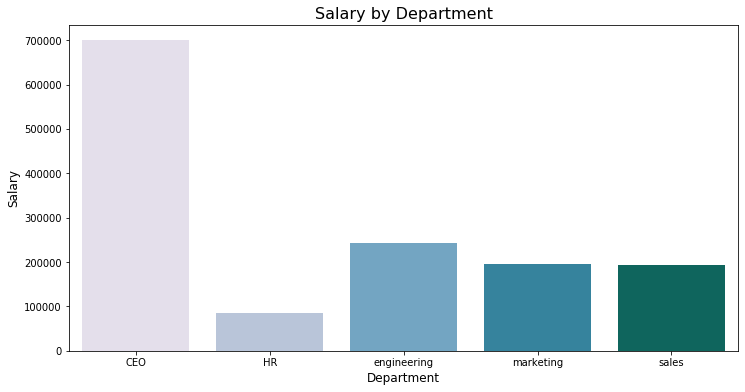

In [13]:
grp_dept = dat[["dept", "salary"]].groupby("dept").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "dept", y = "salary", data = grp_dept, palette = "PuBuGn")
plt.title("Salary by Department", fontsize = 16)
plt.xlabel("Department", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

Text(0, 0.5, 'Salary')

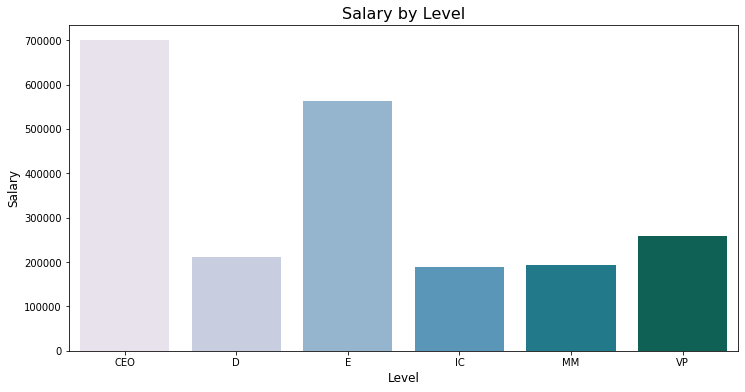

In [14]:
grp_level = dat[["level", "salary"]].groupby("level").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "level", y = "salary", data = grp_level, palette = "PuBuGn")
plt.title("Salary by Level", fontsize = 16)
plt.xlabel("Level", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

Text(0, 0.5, 'Salary')

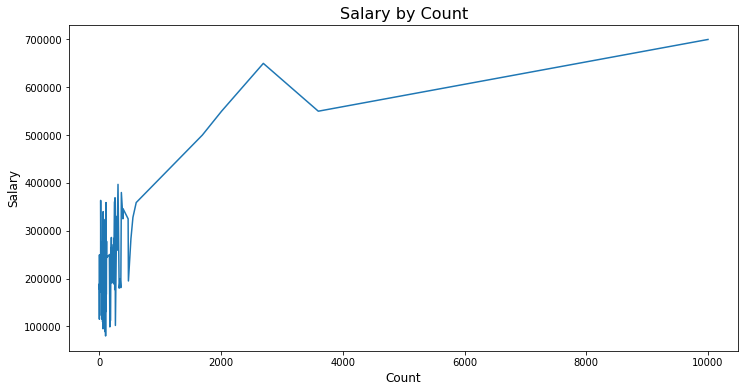

In [15]:
grp_count = dat[["count", "salary"]].groupby("count").mean().reset_index()
plt.figure(figsize = [12, 6])
sns.lineplot(x = "count", y = "salary", data = grp_count, palette = "PuBuGn")
plt.title("Salary by Count", fontsize = 16)
plt.xlabel("Count", fontsize = 12)
plt.ylabel("Salary", fontsize = 12)

In [16]:
#### Initialize H2O cluster
h2o.init()
h2o.remove_all()

dat_h2o = H2OFrame(dat)
dat_h2o["signing_bonus"] = dat_h2o["signing_bonus"].asfactor()
dat_h2o["degree_level"] = dat_h2o["degree_level"].asfactor()
dat_h2o["sex"] = dat_h2o["sex"].asfactor()
dat_h2o["dept"] = dat_h2o["dept"].asfactor()
dat_h2o["level"] = dat_h2o["level"].asfactor()
dat_h2o.summary()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/kq/wd0bz4wn3hj9lylc5lbr2h140000gn/T/tmprq3ceyhy
  JVM stdout: /var/folders/kq/wd0bz4wn3hj9lylc5lbr2h140000gn/T/tmprq3ceyhy/h2o_veronica_started_from_python.out
  JVM stderr: /var/folders/kq/wd0bz4wn3hj9lylc5lbr2h140000gn/T/tmprq3ceyhy/h2o_veronica_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_veronica_csxwvd
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%


,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,count
type,int,enum,int,enum,enum,int,int,enum,enum,int
mins,40.0,,60000.0,,,1.0,79.0,,,0.0
mean,100001.85580000032,,189111.79999999885,,,3.8751999999999995,103299.98049804989,,,4.875399999999999
maxs,199956.0,,700000.0,,,34.0,199950.0,,,9999.0
sigma,57500.48864100209,,88973.7968978139,,,3.1074089784024066,57508.79881677934,,,114.47917986735541
zeros,0,,0,,,0,0,,,9001
missing,0,0,0,0,0,0,1,0,0,0
0,138719.0,0,273000.0,Master,M,2.0,43602.0,engineering,IC,0.0
1,3192.0,0,301000.0,Bachelor,F,1.0,87847.0,sales,IC,0.0
2,114657.0,0,261000.0,Master,F,2.0,180854.0,sales,IC,0.0


In [17]:
index = dat_h2o["salary"].stratified_split(test_frac = 0.34, seed = 2019)
train_dat = dat_h2o[index == "train"]
test_dat = dat_h2o[index == "test"]
X = ["signing_bonus", "degree_level", "sex", "yrs_experience", "dept", "level", "count"]
Y = "salary"

In [18]:
RF = H2ORandomForestEstimator(balance_classes = False, ntrees = 100, max_depth = 20, 
                              mtries = -1, seed = 2019, score_each_iteration = True)
RF.train(x = X, y = Y, training_frame = train_dat)

drf Model Build progress: |███████████████████████████████████████████████| 100%


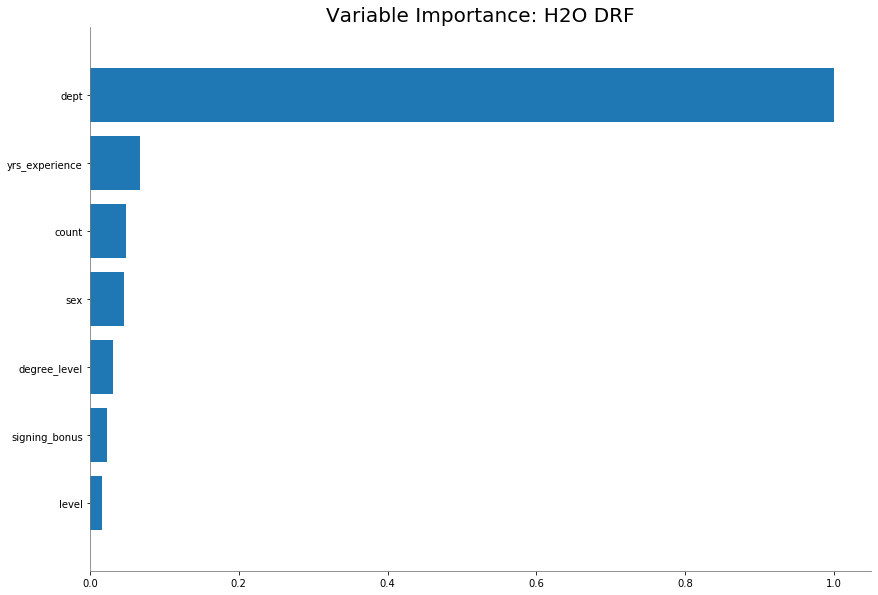

In [19]:
RF.varimp_plot()

#### (4) Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

Text(0, 0.5, 'Count')

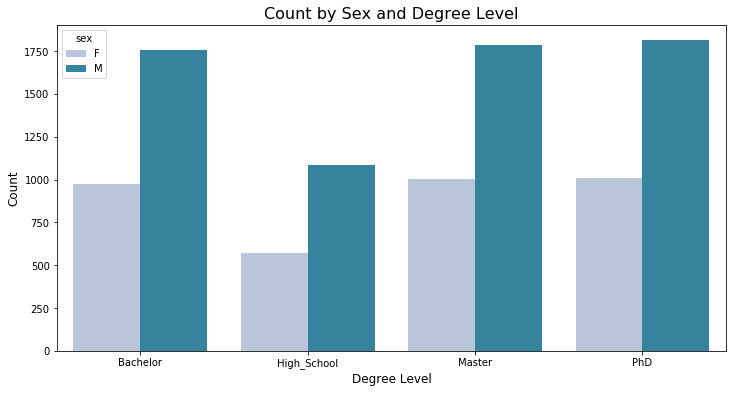

In [20]:
grp_sex_degree = dat[["degree_level", "sex", "salary"]].groupby(["degree_level", "sex"]).count().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "degree_level", y = "salary", hue = "sex", data = grp_sex_degree, palette = "PuBuGn")
plt.title("Count by Sex and Degree Level", fontsize = 16)
plt.xlabel("Degree Level", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

Text(0, 0.5, 'Count')

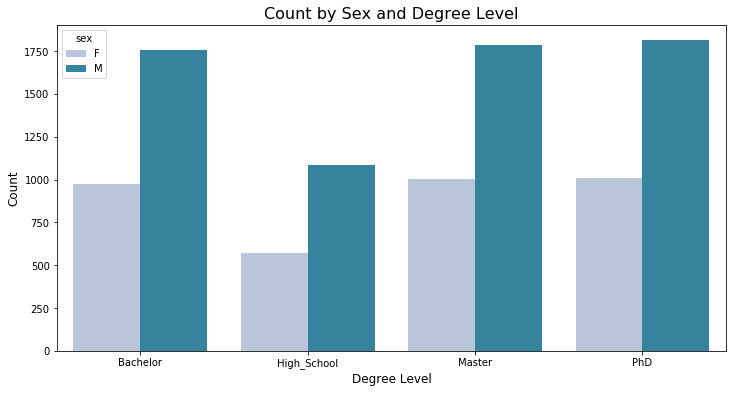

In [21]:
grp_sex_degree = dat[["degree_level", "sex", "salary"]].groupby(["degree_level", "sex"]).count().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "degree_level", y = "salary", hue = "sex", data = grp_sex_degree, palette = "PuBuGn")
plt.title("Count by Sex and Degree Level", fontsize = 16)
plt.xlabel("Degree Level", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

Text(0, 0.5, 'Count')

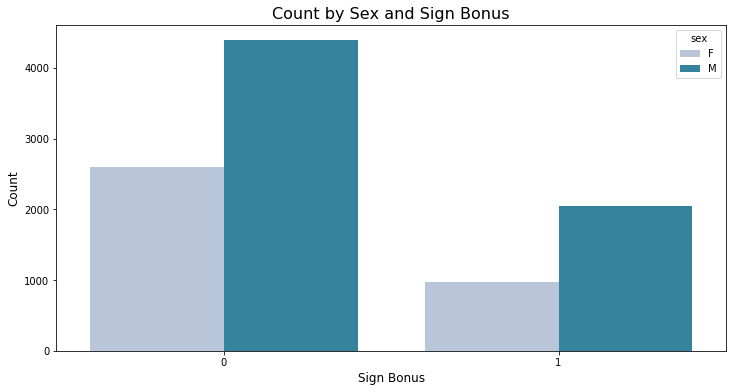

In [22]:
grp_sex_sign_bonus = dat[["signing_bonus", "sex", "salary"]].groupby(["signing_bonus", "sex"]).count().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "signing_bonus", y = "salary", hue = "sex", data = grp_sex_sign_bonus, palette = "PuBuGn")
plt.title("Count by Sex and Sign Bonus", fontsize = 16)
plt.xlabel("Sign Bonus", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

Text(0, 0.5, 'Count')

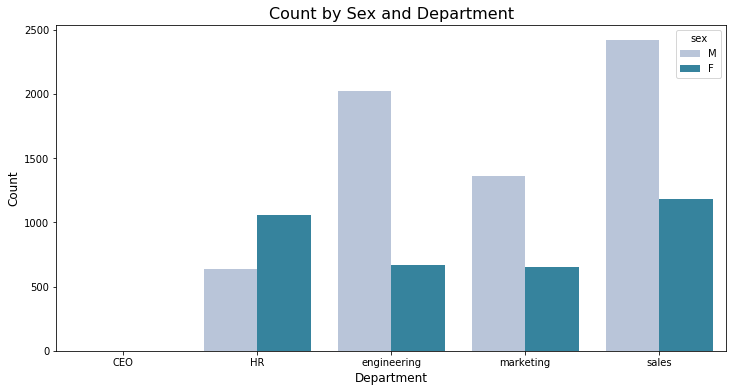

In [23]:
grp_sex_dept = dat[["dept", "sex", "salary"]].groupby(["dept", "sex"]).count().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "dept", y = "salary", hue = "sex", data = grp_sex_dept, palette = "PuBuGn")
plt.title("Count by Sex and Department", fontsize = 16)
plt.xlabel("Department", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

Text(0, 0.5, 'Count')

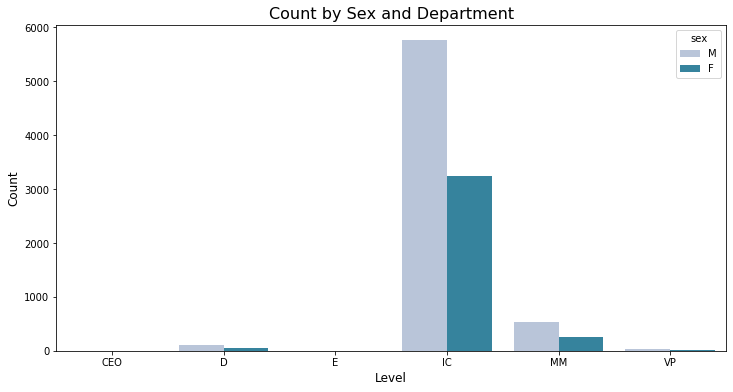

In [24]:
grp_sex_level = dat[["level", "sex", "salary"]].groupby(["level", "sex"]).count().reset_index()
plt.figure(figsize = [12, 6])
sns.barplot(x = "level", y = "salary", hue = "sex", data = grp_sex_level, palette = "PuBuGn")
plt.title("Count by Sex and Department", fontsize = 16)
plt.xlabel("Level", fontsize = 12)
plt.ylabel("Count", fontsize = 12)

See my R solution.